In [1]:
# !pip install selenium
# !pip install dateparser

import datetime
import datetime as dt
from datetime import timedelta
import dateparser

import pandas as pd
import numpy as np

from selenium import webdriver
from selenium import common
from selenium.webdriver.common.keys import Keys
import time

# parser class

In [26]:
class Weather_parser:
    
    def __init__(self, date_start=None, date_end=datetime.date.today(), number_of_dates=None, current_data_df=None):
        """
        date_start: datetime.date
        date_end: datetime.date
        number_of_dates: int
        current_data_df: pd.DateFrame, columns = ['Station', 'Date', 'Hour'] + variables
        """
        self.date_start = date_start
        self.date_end = date_end
        self.current_data_df = current_data_df
        self.exceptions = {}
        
        if self.date_start and (self.date_start > self.date_end):
            raise Exception('Start cannot exceed end')
        
        if self.current_data_df is not None:
            # last date
            (day, month, year) = self.current_data_df.Date.values[-1].split('.')
            self.date_start = datetime.date(int(year), int(month), int(day)+1)
            self.number_of_dates = (self.date_end - self.date_start).days + 1
        
        elif number_of_dates is None:
            self.number_of_dates = (self.date_end - self.date_start).days + 1
        else:
            self.number_of_dates = number_of_dates + 1
            
        self.find_target_dates()
        
    def to_datestring(self, date):
        return f"{date.day}.{date.month}.{date.year}"

    def from_datestring(self, datestring):
        return dateparser.parse(datestring).date()
    
    def find_target_dates(self):
        self.dates = [self.to_datestring(self.date_start + timedelta(days=i)) for i in range(self.number_of_dates)]
    
    def set_date(self, date_string):
        cal = self.wd.find_element_by_xpath('//*[@id="calender_archive"]')
        for _ in range(20):
            cal.send_keys(Keys.BACKSPACE)
        time.sleep(0.01)
        cal.send_keys(date_string)
        time.sleep(0.01)
        select_button = self.wd.find_element_by_xpath('//*[@id="toScreenMenu"]/form/table/tbody/tr/td[5]/div/div')
        select_button.click()
        time.sleep(0.05)
        
    def crawl_hour(self, source, date, hour):
            row = [source, date, 26-hour]
            for (varname, varnum) in variables:
                try:
                    if hour==2:
                        other_val = self.wd.find_element_by_xpath(f'//*[@id="archiveTable"]/tbody/tr[{hour}]/td[{varnum+1}]/div[1]').text
                    else:
                        other_val = self.wd.find_element_by_xpath(f'//*[@id="archiveTable"]/tbody/tr[{hour}]/td[{varnum}]/div[1]').text
                    row.append(other_val)
                    
                except Exception as e:
                    self.exceptions[source, date, hour] = e
                    row.append(np.nan)
            return np.array(row)
        
    def crawl_source(self, source, source_link, variables, note=''):
        self.wd = webdriver.Chrome()
        self.source_arr = np.array([['Station', 'Date', 'Hour'] + [tup[0] for tup in variables]])
        
        if self.current_data_df is not None:
            self.source_arr = np.concatenate([self.source_arr, self.current_data_df.values])
        
        columns = ['Station', 'Date', 'Hour'] + [tup[0] for tup in variables]
        print('Downloading ', source)

        try:
            self.wd.get(source_link)
            cal = self.wd.find_element_by_xpath('//*[@id="calender_archive"]')

            for date in self.dates:
                self.set_date(date)
                for hour in range(2,26):
                    self.row = self.crawl_hour(source, date, hour)
                    self.row = np.array([self.row])
                    self.source_arr = np.concatenate([self.source_arr, self.row])

            self.df = pd.DataFrame(data=self.source_arr)
            self.df.columns = self.df.iloc[0]
            self.df.drop(0, inplace=True)
            self.df.to_pickle(f'weather_history_{source}_{str(self.date_start)}_{str(self.date_end)}_{note}.pickle')
            print(source, ' done')
                
        except Exception as e:
            print(source, ' failed')
            self.exceptions[source] = e
                
        self.wd.close()

In [27]:
sources = {
#     'Kbely' : "https://rp5.ru/Weather_archive_in_Prague,_Kbely",
    'Edinburgh': "https://rp5.ru/Weather_archive_in_Edinburgh_(airport)"
#     'Vary' : "https://rp5.ru/Weather_archive_in_Karlovy_Vary_(airport)",
#    'Budejce': 'https://rp5.ru/Weather_archive_in_Ceske_Budejovice,_Roznov',
#    'Brno': 'https://rp5.ru/Weather_archive_in_Brno,_Turany_(airport)',
#            'Prostejov': 'https://rp5.ru/Weather_archive_in_Prostejov_(airport)',
#            'Ostrava': 'https://rp5.ru/Weather_archive_in_Ostrava,_Mosnov_(airport)',
#            'Pardubice': 'https://rp5.ru/Weather_archive_in_Pardubice_(airport)',
#            'Liberec': 'https://rp5.ru/Weather_archive_in_Liberec',
#            'Usti':'https://rp5.ru/Weather_archive_in_Usti_nad_Labem',
#             'Plzen': 'https://rp5.ru/Weather_archive_in_Plzen',
#             'Holesov': 'https://rp5.ru/Weather_archive_in_Holesov',
#         'Pribyslav': 'https://rp5.ru/Weather_archive_in_Pribyslav'
          }

In [28]:
start = dt.date(2020, 10, 5)
end = dt.date(2020, 10, 10)

parser = Weather_parser(date_start=start, date_end=end)

variables = [('temperature', 2), ('precipitation', 24)]

In [29]:
%%time

parser.crawl_source(source = 'Edinburgh', source_link = sources['Edinburgh'], variables=variables)

Edinburgh  done
Wall time: 19.5 s


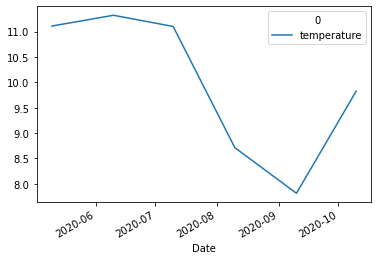

In [31]:
df = pd.read_pickle('weather_history_Edinburgh_2020-10-05_2020-10-10_.pickle')
df['Date'] = pd.DatetimeIndex(df['Date'])
df['temperature'] = df['temperature'].astype(float)
df.set_index('Date').groupby('Date').mean().plot()

# Join pickles

In [6]:
pd.read_pickle('weather_history_Kbely2019.pickle').tail()

FileNotFoundError: [Errno 2] No such file or directory: 'weather_history_Kbely2019.pickle'

In [ ]:
columns = ['Station', 'Date', 'Hour'] + [tup[0] for tup in variables]

df = pd.DataFrame(columns=columns)

for source in sources.keys():
    try:
        df = df.append(pd.read_pickle(f'weather_history_{source}.pickle'))
    except TypeError:
        print(source)

In [ ]:
df.to_pickle('weather_history_all.pickle')

In [ ]:
pd.read_pickle('weather_history_all.pickle').tail()